In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def image_to_vector(image_path):
    image = Image.open(image_path)
    image_data = np.asarray(image)
    return image_data.flatten()

In [3]:
np.random.seed(8)

fig_size = (32, 32)
vector_dimension = fig_size[0] * fig_size[1]

choice = [i * 7 % 68 for i in range(1, 25 + 1)]
pic_root_folder = "PIE"
selfish_folder = "0"
train_set_name, test_set_name = [], []
for i in choice:
    images = [f'{i}/{filename}' for filename in os.listdir(f'{pic_root_folder}/{i}')]
    np.random.shuffle(images)
    train_size = int(len(images) * 0.7)
    train_set_name += images[:train_size]
    test_set_name += images[train_size:]

self_images = [f'{selfish_folder}/{filename}' for filename in os.listdir(f'{pic_root_folder}/{selfish_folder}')]
np.random.shuffle(self_images)
selfish_train_set_name = self_images[:7]
selfish_test_set_name = self_images[7:]
train_set_name += selfish_train_set_name

# Generate the label for each set
train_set_label = np.array([int(i.split('/')[0]) for i in train_set_name])
test_set_label = np.array([int(i.split('/')[0]) for i in test_set_name])
selfish_test_set_label = np.array([int(i.split('/')[0]) for i in selfish_test_set_name]) # Mark selfish as type

# Read and transform image data
train_set_data = np.zeros((len(train_set_name), vector_dimension))
test_set_data = np.zeros((len(test_set_name), vector_dimension))
selfish_test_set_data = np.zeros((len(selfish_test_set_name), vector_dimension))
for i in range(len(train_set_name)):
    train_set_data[i, :] = image_to_vector(f'{pic_root_folder}/{train_set_name[i]}')
for i in range(len(test_set_name)):
    test_set_data[i, :] = image_to_vector(f'{pic_root_folder}/{test_set_name[i]}')
for i in range(len(selfish_test_set_name)):
    selfish_test_set_data[i, :] = image_to_vector(f'{pic_root_folder}/{selfish_test_set_name[i]}')

In [4]:
class PCA:
    def __init__(self, data):
        self.mean = np.mean(data, axis=0)
        X_d_n = data - self.mean
        U, S, V_t = np.linalg.svd(X_d_n)
        self.V = V_t.T

    def construct(self, data, dimension):
        X_d_n = data - self.mean
        return X_d_n @ self.V[:,:dimension]

    def get_component(self, n):
        return self.V.T[n, :]
    
    def get_eigenface(self, n):
        eigenface = self.get_component(n)
        normalized_eigenface = (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface)) * 255
        return Image.fromarray(normalized_eigenface.astype(np.uint8).reshape(32, 32), 'L')


In [5]:
random_indices = np.random.choice(len(train_set_data), 500, replace=True)
selected_500_data = train_set_data[random_indices]
selected_500_label = train_set_label[random_indices]
labels_in_train_set = np.unique(selected_500_label)
labels_in_train_set.sort()

pca = PCA(selected_500_data)

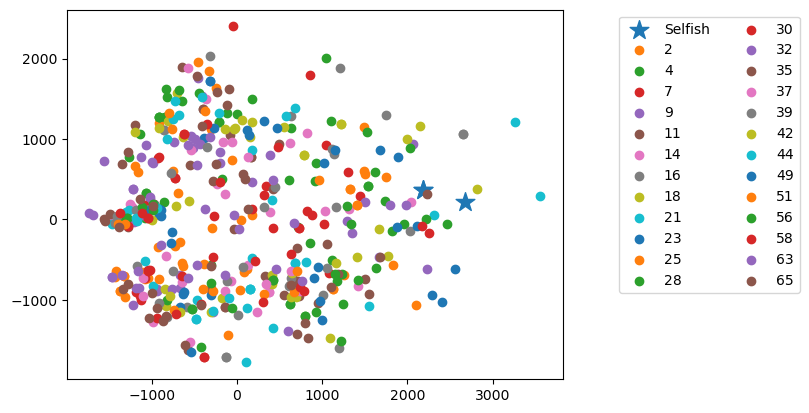

In [6]:
X_2d = pca.construct(selected_500_data, dimension = 2)
plt.scatter(X_2d[selected_500_label==0,0], X_2d[selected_500_label==0,1], label = 'Selfish', marker='*', s = 200)
for i in labels_in_train_set[1:]:
    plt.scatter(X_2d[selected_500_label==i,0], X_2d[selected_500_label==i,1], label = i)
plt.legend(ncol=2, bbox_to_anchor=(1.1, 1))
plt.show()

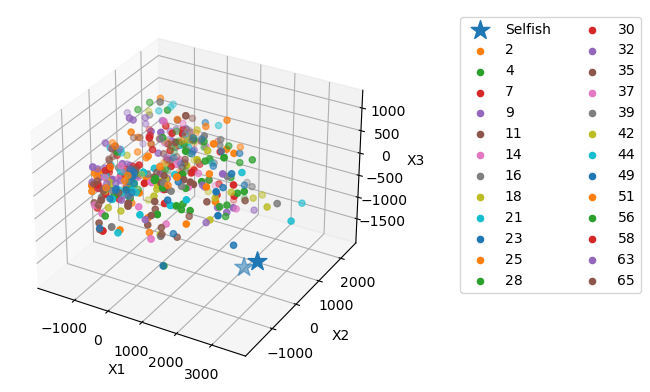

In [7]:
X_3d = pca.construct(selected_500_data, dimension = 3)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_3d[selected_500_label==0,0], X_3d[selected_500_label==0,1], X_3d[selected_500_label==0,2], label = 'Selfish', marker='*', s = 200)
for i in labels_in_train_set[1:]:
    ax.scatter(X_3d[selected_500_label==i,0], X_3d[selected_500_label==i,1], X_3d[selected_500_label==i,2], label = i)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.legend(ncol=2, bbox_to_anchor=(1.2, 1))
plt.show()

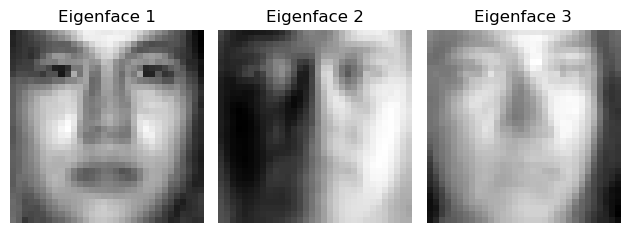

In [8]:
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(pca.get_eigenface(i), cmap='gray')
    plt.title(f'Eigenface {i+1}')
    plt.axis(False)

plt.tight_layout()
plt.show()

In [9]:
class NearstNeighbor:
    def __init__(self, train_data, label):
        self.data = train_data
        self.label = label

    def compute_distance(A, B):
        distances = np.zeros((A.shape[0], B.shape[0]))
        for i, row_A in enumerate(A):
            for j, row_B in enumerate(B):
                distances[i, j] = np.linalg.norm(row_A - row_B)
        return distances
    
    def classify(self, test_data):
        distance = NearstNeighbor.compute_distance(test_data, self.data)
        index = np.argmin(distance, axis = 1)
        return self.label[index]
        

In [10]:
pca = PCA(train_set_data)

for d in [40, 80, 200]:
    X_train = pca.construct(train_set_data, dimension = d)
    X_test_PIE = pca.construct(test_set_data, dimension = d)
    X_test_Selfish = pca.construct(selfish_test_set_data, dimension = d)
    NN = NearstNeighbor(X_train, train_set_label)
    predict_result_PIE = NN.classify(X_test_PIE)
    predict_result_Selfish = NN.classify(X_test_Selfish)
    accuary_PIE = np.sum(predict_result_PIE == test_set_label)/predict_result_PIE.size
    accuary_Selfish = np.sum((predict_result_Selfish == selfish_test_set_label)/predict_result_Selfish.size)
    print(f'Dimension {d}: Accuracy on PIE = {accuary_PIE}')
    print(f'Dimension {d}: Accuracy on Selfish = {accuary_Selfish}')
    print()

Dimension 40: Accuracy on PIE = 0.9115384615384615
Dimension 40: Accuracy on Selfish = 1.0

Dimension 80: Accuracy on PIE = 0.9338461538461539
Dimension 80: Accuracy on Selfish = 1.0

Dimension 200: Accuracy on PIE = 0.9415384615384615
Dimension 200: Accuracy on Selfish = 1.0

